In [1]:
import os

from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVR

from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import pearsonr
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import get_stats, mixup, write_pickled_object
from utils import FeatureSelector, MeanCenterer

In [2]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 42 + 5

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

In [3]:
class ModalitySelector(BaseEstimator, TransformerMixin):
    def __init__(self, modality):
        if modality not in ['protein', 'rna']:
            raise ValueError("modality must be 'protein' or 'rna'")
        self.modality = modality

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X is expected to be a tuple: (X_protein, X_rna)
        if self.modality == 'protein':
            return X[0]  # Return X_protein
        elif self.modality == 'rna':
            return X[1]  # Return X_rna

In [4]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_joint.csv'), index_col = 0)
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_joint.csv'), index_col = 0)['mean'].values.ravel()

expr_protein = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0)
expr_rna = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0)

protein_cols = expr_protein.columns
rna_cols = expr_rna.columns

X_protein = X[protein_cols].values
X_rna = X[rna_cols].values

X = X.values

Let's take a look at the results from the model selection:

In [5]:
res = pd.read_csv(os.path.join(data_path, 'interim', 'pipeline_model_selection_joint.csv'), index_col = 0)

In [6]:
res.test_corr.median()

np.float64(0.3703700767126024)

In [7]:
res.test_corr.mean()

np.float64(0.3996435127888384)

Select a best consensus model and re-run on new folds to see the performance:

In [13]:
C_best = []
epsilon_best = []
n_features_protein_best = []
# n_features_rna_best = []
for bp in res.best_params:
    print(bp)
    print('------------------------------------------------------')
#     if eval(bp.split(', ')[1].split(': ')[1]) == 'SVR':
    C_best.append(float(bp.split(', ')[3].split(': ')[1]))
    epsilon_best.append(float(bp.split(', ')[-1].split(': ')[1][:-1]))
    n_features_protein_best.append(int(bp.split(', ')[0].split(': ')[1]))
#     n_features_rna_best.append(int(bp.split(', ')[1].split(': ')[1]))

{'FeatureSelector__n_features_protein': 250, 'FeatureSelector__n_features_rna': 19138, 'model_type': 'SVR', 'SVR__C': 0.007575880144977461, 'SVR__epsilon': 0.4815700201402703}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 250, 'FeatureSelector__n_features_rna': 19138, 'model_type': 'SVR', 'SVR__C': 0.006040288632146537, 'SVR__epsilon': 0.24696661799808795}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 250, 'FeatureSelector__n_features_rna': 19138, 'model_type': 'SVR', 'SVR__C': 0.01973441853360897, 'SVR__epsilon': 0.798863937224151}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 5000, 'FeatureSelector__n_features_rna': 19138, 'model_type': 'SVR', 'SVR__C': 1.2846404704272545, 'SVR__epsilon': 1.2732495750388506}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 250, 'FeatureSelector__n_features_rna'

In [15]:
np.mean(n_features_protein_best)

np.float64(1350.0)

500

Looks like consistently, the best performing model uses all features and a linear SVM. We will take the median C and epsiolon value across folds:

In [21]:
protein_pipeline = Pipeline([
    ("select_protein", ModalitySelector(modality="protein")),
    ("feature_selection_protein", FeatureSelector(method="top_n_cv", 
                                                  n_features=int(np.round(np.median(n_features_protein_best))))),
    ("mean_centering_protein", MeanCenterer()),  # Mean centering for protein data
])

# RNA-specific pipeline
rna_pipeline = Pipeline([
    ("select_rna", ModalitySelector(modality="rna")),
    ("feature_selection_rna", FeatureSelector(method="top_n_cv", 
                                              n_features=19138)),
    ("mean_centering_rna", MeanCenterer()),  # Mean centering for RNA data
])

# Combine both pipelines
combined_pipeline = FeatureUnion([
    ("protein_pipeline", protein_pipeline),
    ("rna_pipeline", rna_pipeline),
])

# Add the model
best_steps = [
    ("feature_processing", combined_pipeline),
]

best_steps.append(("model", SVR(
    kernel='linear',
    C=np.median(C_best),
    epsilon=np.median(epsilon_best)
)))
best_pipeline = Pipeline(best_steps)
write_pickled_object(best_pipeline, 
                    os.path.join(data_path, 'processed', 'best_model_joint.pickle'))

In [22]:
np.random.seed(random_state + 1)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=random_state+1)
n_synthetic = 1000
augment = False
# res = {}

baseline_linear = LinearRegression(n_jobs = n_cores)

results = []
for k, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y))):
    X_train_all, X_test_all = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    X_train_rna, X_test_rna = X_rna[train_idx], X_rna[test_idx]
    X_train_protein, X_test_protein = X_protein[train_idx], X_protein[test_idx]
    
    X_train = (X_train_protein, X_train_rna)
    X_test = (X_test_protein, X_test_rna)

    train_corr, test_corr, train_mse, test_mse = get_stats(best_pipeline, y_train, y_test, X_train, X_test)
    
    # random - y
    y_train_rand = np.random.permutation(y_train)
    res_y_rand = get_stats(best_pipeline, y_train_rand, y_test, X_train, X_test)
    _, test_corr_y_rand, _, test_mse_y_rand = res_y_rand    
    
    # random - X (features)
    X_train_rand_protein = X_train_protein[:, np.random.permutation(X_train_protein.shape[1])]
    X_train_rand_rna = X_train_rna[:, np.random.permutation(X_train_rna.shape[1])]
    X_train_rand =  (X_train_rand_protein, X_train_rand_rna)
    res_X_rand = get_stats(best_pipeline, y_train, y_test, X_train_rand, X_test)
    _, test_corr_X_rand, _, test_mse_X_rand = res_X_rand  
    
    # linear simple
    linear_res = get_stats(baseline_linear, y_train, y_test, X_train_all, X_test_all)
    _, test_corr_linear, _, test_mse_linear = linear_res
    

    results.append({
        "fold": k,
        "train_corr": train_corr,
        "test_corr": test_corr,
        'train_mse': train_mse, 
        'test_mse': test_mse,
        'random_y_test_corr': test_corr_y_rand, 
        'random_y_test_mse': test_mse_y_rand, 
        'random_X_test_corr': test_corr_X_rand, 
        'random_X_test_mse': test_mse_X_rand, 
        'linear_baseline_test_corr': test_corr_linear, 
        'linear_baseline_test_mse': test_mse_linear, 
        })
    best_res_df = pd.DataFrame(results)
#     res[k] = {'test': y_test, 'pred': y_test_pred, 'train': y_train}

10it [00:37,  3.78s/it]


In [20]:
viz_df = best_res_df[[col for col in best_res_df if 'test' in col or col == 'fold']]
viz_df_corr = viz_df[[col for col in viz_df if 'corr' in col]]
viz_df_mse = viz_df[[col for col in viz_df if 'mse' in col]]
viz_dfs = {'Pearson Correlation': viz_df_corr, 
          'Mean Squared Error': viz_df_mse}

/tmp/ipykernel_2162337/257398129.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(),
/tmp/ipykernel_2162337/257398129.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(),


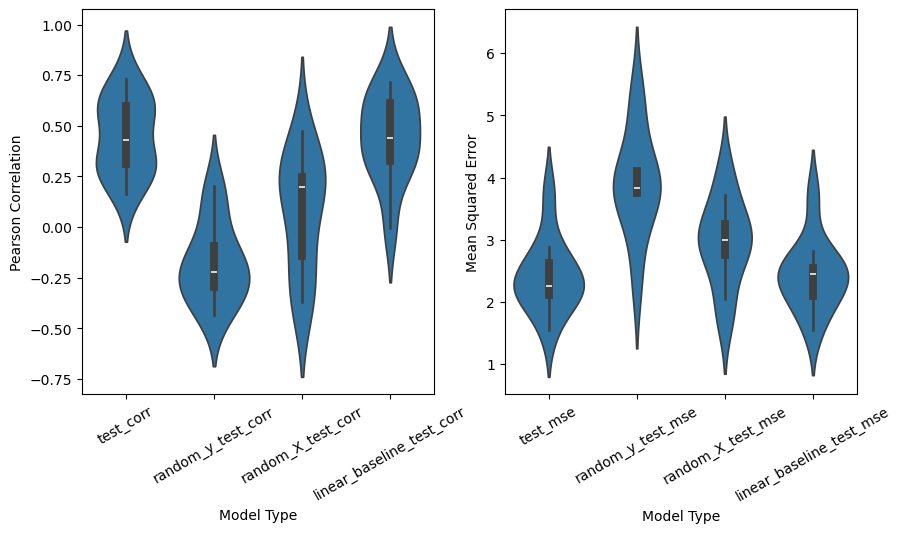

In [21]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))

for i, (metric, viz_df) in enumerate(viz_dfs.items()):
    viz_df = pd.melt(viz_df, value_name=metric, var_name = 'Model Type')
    sns.violinplot(data = viz_df, x = 'Model Type', y = metric, ax = ax[i])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), 
                     rotation = 30, ha = 'center')

In [23]:
best_res_df.test_corr.median()

np.float64(0.4326735209309083)

In [24]:
best_res_df.test_corr.mean()

np.float64(0.4147497813156492)

In [26]:
best_res_df.to_csv(os.path.join(data_path, 'processed', 'consensus_model_res_joint.csv'))

In [28]:
from gseapy import gsea

ModuleNotFoundError: No module named 'gseapy.gse'

# To do:
1) try a different seed?
2) why is the model selection pipeline so much better than the best model here, when it wasn't anywhere else?